In [1]:
import os, sys
cwd = os.getcwd()
module_path = os.path.dirname(cwd)  # target working directory

sys.path = [item for item in sys.path if item != module_path]  # remove module_path from sys.path
sys.path.append(module_path)  # add module_path to sys.path

import os
import glob
import numpy as np
import time
import librosa
import pandas as pd
import seaborn as sns

from joblib import dump, load

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid, cross_validate
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import make_scorer, zero_one_loss, ConfusionMatrixDisplay
from pyrcn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from pyrcn.model_selection import SequentialSearchCV
from pyrcn.util import FeatureExtractor
from pyrcn.datasets import fetch_ptdb_tug_dataset
from pyrcn.echo_state_network import SeqToLabelESNClassifier
from pyrcn.base import InputToNode, PredefinedWeightsInputToNode, NodeToNode, PredefinedWeightsNodeToNode

import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex': True,
          'font.size': 8,
          'font.family': 'lmodern',
         }
plt.rcParams.update(params)
plt.rc('image', cmap='RdBu')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rc('font', **{'family': 'serif'})
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


In [2]:
all_files = glob.glob(r"E:\free-spoken-digit-dataset\recordings\*.wav")
print(len(all_files))

3000


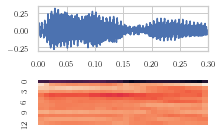

In [18]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
# X = np.vstack((mfcc, mfcc_delta, mfcc_delta2))
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(3.2, 2)

sns.lineplot(x=t, y=x, ax=axs[0])
axs[0].set(xlim=(0, 0.3))
sns.heatmap(data=X.T, ax=axs[1], xticklabels=np.arange(X.shape[0]) / 100, cbar=False)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(10))

"""
axs[0].plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(2, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
"""
plt.tight_layout()

In [27]:
X_train = []
X_test = []
y_train = []
y_test = []
print("extracting features...")
for k, f in enumerate(all_files):
    basename = os.path.basename(f).split('.')[0]
    # Get label (0-9) of recording.
    label = int(basename.split('_')[0])
    idx = int(basename.split('_')[2])
    # Load the audio signal and normalize it.
    x, sr = librosa.core.load(f, sr=None, mono=False)
    # x /= np.max(np.abs(x))
    mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    if idx <= 4:
        X_test.append(mfcc.T)
        y_test.append(label)
    else:
        X_train.append(mfcc.T)
        y_train.append(label)
print("done!")
X_train, y_train = shuffle(X_train, y_train, random_state=0)

extracting features...
done!


In [28]:
scaler = StandardScaler().fit(X=np.vstack(X_train + X_test))
X_train_scaled = np.empty(shape=(len(X_train),), dtype=object)
X_test_scaled = np.empty(shape=(len(X_test),), dtype=object)
y_train = np.array(y_train, dtype=object)
y_test = np.array(y_test, dtype=object)
for k in range(len(X_train)):
    X_train_scaled[k] = scaler.transform(X_train[k])
    y_train[k] = np.atleast_1d(y_train[k]).astype(int)
for k in range(len(X_test)):
    X_test_scaled[k] = scaler.transform(X_test[k])
    y_test[k] = np.atleast_1d(y_test[k]).astype(int)

In [29]:
print(len(X_train), len(y_train), X_train[0].shape, y_train[0])
print(len(X_test), len(y_test), X_test[0].shape, y_test[0])

2700 2700 (37, 13) [8]
300 300 (30, 13) [0]


In [30]:
initially_fixed_params = {'hidden_layer_size': 50,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': loguniform(1e-5, 1e1)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

base_esn = SeqToLabelESNClassifier(**initially_fixed_params)

try:
    sequential_search = load("../sequential_search_fsdd.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train_scaled, y_train)
    dump(sequential_search, "../sequential_search_fsdd.joblib")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 39.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 49.4min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 11.0min finished


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  2.4min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 11.0min finished
